<a href="https://colab.research.google.com/github/khadija267/AI-for-Cyber-Security/blob/main/Network_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Time Series Anomaly Detection
There are nine abnormal categories.

## Get Data

Import necessary libraries

In [8]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:

from google.colab import drive
drive.mount('/content/drive')

# Specify the path to the file in your Google Drive
file_path = '/content/drive/My Drive/NetT_data.zip'
file_path1 = '/content/drive/My Drive/FS_description.csv'

# Copy the file to the Colab instance
import shutil
shutil.copy(file_path, '.')
shutil.copy(file_path1, '.')

# Confirm that the file has been copied
!ls

Mounted at /content/drive
drive  FS_description.csv  NetT_data.zip  sample_data


In [3]:
!unzip -- NetT_data.zip

Archive:  NetT_data.zip
  inflating: NetT_data.csv           


## Data Investigation

In [2]:
metadata=pd.read_csv('FS_description.csv')
metadata.head(100)

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,cat 1,nominal,Transaction protocol
5,6,cat 3,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


In [3]:
df=pd.read_csv('NetT_data.csv')
df.head()


,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Bin_Label,Multi_Label
0,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:53:30,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,57602502.0,6.306497e+07,102196170.0,13008834.0,115205004.0,57602502.0,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,1.300883e+07,0,0
1,244.15.103.115-192.168.1.79-0-0-0,244.15.103.115,0,192.168.1.79,0,0,2019-02-04 19:54:38,6039467,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496733,3019733.5,1.373953e+06,3991265.0,2048202.0,6039467.0,3019733.5,1.373953e+06,3991265.0,2048202.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.496733,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.554199e+15,0.000000e+00,1.554199e+15,1.554199e+15,0,0
2,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:55:58,65536962,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045776,32768481.0,1.564027e+07,43827824.0,21709138.0,65536962.0,32768481.0,1.564027e+07,43827824.0,21709138.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.045776,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973172e+14,1.554199e+15,2.170914e+07,0,0
3,41.238.224.122-192.168.1.190-0-0-0,41.238.224.122,0,192.168.1.190,0,0,2019-02-04 19:57:37,90177027,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,45088513.5,4.231300e+07,75008320.0,15168707.0,90177027.0,45088513.5,4.231300e+07,75008320.0,15168707.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.033268,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,1.516871e+07,0,0
4,177.30.87.144-192.168.1.1-0-0-0,177.30.87.144,0,192.168.1.1,0,0,2019-02-04 19:58:04,111616761,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026878,55808380.5,1.880029e+06,57137762.0,54478999.0,111616761.0,55808380.5,1.880029e+06,57137762.0,54478999.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026878,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,5.447900e+07,0,0


In [ ]:
df.shape

In [ ]:
df.describe()

## Data Preparation

In [ ]:
df.duplicated().sum()

0

In [ ]:
# makesure that we have no missing data
df.isna().any().any()

False

In [ ]:
# Information of data columns
df.info()

In [4]:
#IP addresses is spoofed by attaker hence it is not an independent feature.
# https://www.researchgate.net/publication/309467794_A_study_on_efficient_detection_of_network-based_IP_spoofing_DDoS_and_malware-infected_Systems
df.drop(['Flow ID','Src IP','Src Port','Dst IP','Dst Port','Bin_Label'], inplace=True,axis=1)

In [13]:
df.head(20
        )

,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Multi_Label
0,0,2019-02-04 19:53:30,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,5.760250e+07,6.306497e+07,102196170.0,13008834.0,115205004.0,5.760250e+07,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,1.300883e+07,0
1,0,2019-02-04 19:54:38,6039467,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496733,3.019734e+06,1.373953e+06,3991265.0,2048202.0,6039467.0,3.019734e+06,1.373953e+06,3991265.0,2048202.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.496733,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.554199e+15,0.000000e+00,1.554199e+15,1.554199e+15,0
2,0,2019-02-04 19:55:58,65536962,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045776,3.276848e+07,1.564027e+07,43827824.0,21709138.0,65536962.0,3.276848e+07,1.564027e+07,43827824.0,21709138.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.045776,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973172e+14,1.554199e+15,2.170914e+07,0
3,0,2019-02-04 19:57:37,90177027,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,4.508851e+07,4.231300e+07,75008320.0,15168707.0,90177027.0,4.508851e+07,4.231300e+07,75008320.0,15168707.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.033268,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,1.516871e+07,0
4,0,2019-02-04 19:58:04,111616761,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026878,5.580838e+07,1.880029e+06,57137762.0,54478999.0,111616761.0,5.580838e+07,1.880029e+06,57137762.0,54478999.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026878,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,5.447900e+07,0
5,0,2019-02-04 19:59:07,40255700,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049682,4.025570e+07,0.000000e+00,40255700.0,40255700.0,40255700.0,4.025570e+07,0.000000e+00,40255700.0,40255700.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.049682,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,7.770996e+14,1.098985e+15,1.554199e+15,4.025570e+07,0
6,0,2019-02-04 20:00:37,73428081,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040856,3.671404e+07,2.484103e+07,54279303.0,19148778.0,73428081.0,3.671404e+07,2.484103e+07,54279303.0,19148778.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.040856,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973173e+14,1.554199e+15,1.914878e+07,0
7,0,2019-02-04 20:03:01,56417287,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053175,2.820864e+07,6.880222e+06,33073695.0,23343592.0,56417287.0,2.820864e+07,6.880222e+

In [8]:
df['Protocol'].value_counts()

6     4126067
17     690635
0      535058
Name: Protocol, dtype: int64

In [ ]:
df['Tot Fwd Pkts'].value_counts()

2        1636302
1        1222316
5         708612
6         572912
3         420508
          ...   
1599           1
2709           1
1830           1
4956           1
12371          1
Name: Tot Fwd Pkts, Length: 1820, dtype: int64

In [5]:

#after feature scaling we found the dataset contains infinte records
#to be removed from the data by replace it into NaN then to drop the Nans
df = df.replace([np.inf, -np.inf], np.nan)
df.dropna(inplace=True)

In [17]:
df.shape

(5350583, 79)

In [6]:

# Convert the timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index(['Timestamp'])

,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Multi_Label
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-04 19:53:30,0,115205004,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026041,57602502.0,6.306497e+07,102196170.0,13008834.0,115205004.0,57602502.0,6.306497e+07,102196170.0,13008834.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026041,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973171e+14,1.554199e+15,1.300883e+07,0
2019-02-04 19:54:38,0,6039467,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.496733,3019733.5,1.373953e+06,3991265.0,2048202.0,6039467.0,3019733.5,1.373953e+06,3991265.0,2048202.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.496733,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.554199e+15,0.000000e+00,1.554199e+15,1.554199e+15,0
2019-02-04 19:55:58,0,65536962,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045776,32768481.0,1.564027e+07,43827824.0,21709138.0,65536962.0,32768481.0,1.564027e+07,43827824.0,21709138.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.045776,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180663e+14,8.973172e+14,1.554199e+15,2.170914e+07,0
2019-02-04 19:57:37,0,90177027,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033268,45088513.5,4.231300e+07,75008320.0,15168707.0,90177027.0,45088513.5,4.231300e+07,75008320.0,15168707.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.033268,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,1.516871e+07,0
2019-02-04 19:58:04,0,111616761,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026878,55808380.5,1.880029e+06,57137762.0,54478999.0,111616761.0,55808380.5,1.880029e+06,57137762.0,54478999.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.026878,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,5.180664e+14,8.973172e+14,1.554199e+15,5.447900e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-30 00:45:55,0,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333333.333333,6.0,0.000000e+00,6.0,6.0,6.0,6.0,0.000000e+00,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,333333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.556549e+15,0.000000e+00,1.556549e+15,1.556549e+15,0
2019-04-30 00:45:55,0,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,666666.666667,3.0,0.000000e+00,3.0,3.0,3.0,3.0,0.000000e+00,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,666666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,

## Dimensionality Reduction

In [ ]:
# define the VAE model architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # the mean layer
        #This layer outputs the mean values of the Gaussian distribution over the latent space.
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        # the log-variance layer
        # This layer outputs the log-variances of the Gaussian distribution over the latent space.
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x.view(-1, input_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# define the training loop
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

# generate a sample from the latent space
def generate_sample(model, num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim)
        sample = model.decode(z).cpu()
    return sample.numpy()

# load the data
data = np.load('data.npy')
input_dim = data.shape[2]
timesteps = data.shape[1]
train_loader = DataLoader(TensorDataset(torch.tensor(data).float()), batch_size=128, shuffle=True)

# set up the model and optimizer
hidden_dim = 512
latent_dim = 2
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# train the model
epochs = 50
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)

# generate a sample from the latent space and plot it
num_samples = 1000
sample = generate_sample(model, num_samples)
plt.scatter(sample[:, 0], sample[:, 1])
plt.show()

# use the elbow method to choose the number of dimensions in the latent space
losses = []
for dim in range(1, input_dim+1):
    model = VAE(timesteps*dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    data_flat = np.reshape(data, (data.shape[0], -1))
    train_loader = DataLoader(TensorDataset(torch.tensor(data_flat).float()), batch_size=128, shuffle=True)
    for epoch in range(1, epochs + 1):
        train(model, train_loader, optimizer, epoch)
    losses.append(loss_function(model(data_flat)[0], torch.tensor(data_flat).float(), model(data_flat)[1], model(data_flat)[2]).item())

plt.plot(range(1, input_dim+1), losses)
plt.show()

In [ ]:
'''
# Define the dimensions of the latent space
latent_dim = 9
Intermediate_dim=6
nb_epoch=1000
batch_size=100
optimizer='adam'
# Define the V-AE architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        return nn.functional.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Load the dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(X_train, batch_size=128, shuffle=False)

# Initialize the V-AE and set the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train the V-AE
model.train()
for epoch in range(50):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Encode the data to the latent space
model.eval()
encoded_data = []
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        _, mu, _ = model(data)
        encoded_data.append(mu.cpu().numpy())
encoded_data = np.concatenate(encoded_data, axis=0)

# Print the shape of the encoded data
print(encoded_data.shape)
'''



## Class Imbalance Handling using SMOTE

In [10]:


# Separate the features and the target variable
X = df.drop('Multi_Label', axis=1)
y = df['Multi_Label']
# Split the data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.2, random_state=42,shuffle=False)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42,shuffle=False)

0    2515236
1    2149308
2     340208
4     277696
3      36205
6      27145
5       5098
7        517
8        202
9        145
Name: Multi_Label, dtype: int64


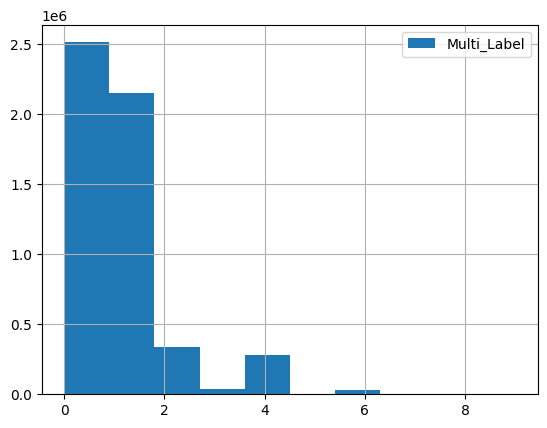

In [9]:
print(df['Multi_Label'].value_counts())
df['Multi_Label'].hist(legend=True);

In [8]:

# Apply SMOTE to oversample the minority class, including the timestamp column
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Print the class distribution before and after SMOTE
print("Before SMOTE:")
print(y.value_counts())
print("\nAfter SMOTE:")
print(y_resampled.value_counts())

DTypePromotionError: ignored

In [ ]:
print(df['Multi_Label'].value_counts())
df['Multi_Label'].hist(legend=True);

Due to the large size of the data we are going to use undersampling technique to handle class imbalance

By splitting the data before applying undersampling, we ensure that the test set remains representative of the original data

In [ ]:
X, y = df.drop(columns=['Multi_Label']), df.Multi_Label
X.shape, y.shape

((5350583, 77), (5350583,))

##  Feature Extraction

In [ ]:
'''
import numpy as np
import pandas as pd


# Load the data
data = pd.read_csv('data.csv')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Define the V-AE model
input_dim = X_train_norm.shape[1]
latent_dim = 10

input_layer = Input(shape=(input_dim,))
hidden_layer_1 = Dense(64, activation='relu')(input_layer)
hidden_layer_2 = Dense(32, activation='relu')(hidden_layer_1)
z_mean = Dense(latent_dim)(hidden_layer_2)
z_log_var = Dense(latent_dim)(hidden_layer_2)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])
decoded = Dense(input_dim, activation='sigmoid')(z)

vae = Model(input_layer, decoded)
vae.compile(optimizer='adam', loss='mean_squared_error')

# Train the V-AE model
vae.fit(X_train_norm, X_train_norm, epochs=10, batch_size=32)

# Extract features from the V-AE model
encoder = Model(input_layer, z_mean)
X_train_encoded = encoder.predict(X_train_norm)
X_test_encoded = encoder.predict(X_test_norm)

# Train a LightGBM model
model = lgb.LGBMClassifier()
model.fit(X_train_encoded, y_train)

# Evaluate the LightGBM model
y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))
'''

In [ ]:

#!pip install keras==2.1.6

In [ ]:
'''
import numpy as np
import pandas as pd
import random

from keras.models import Sequential
from keras.layers.core import Dense, Activation

from keras.layers.recurrent import LSTM
from keras.layers import Input, LSTM, RepeatVector, Masking, TimeDistributed, Lambda
from keras.losses import mse, binary_crossentropy, mean_squared_error
from keras.models import Model
from keras import backend as K


#define variables
latent_dim=9
Intermediate_dim=6
nb_epoch=1000
batch_size=100
optimizer='adam'
#X is the data matrix

#encoder LSTM
inputs = Input(shape=(7, 1), name='InputTimeSeries')  #(timesteps, input_dim)
encoded = LSTM(Intermediate_dim, name='EncoderLSTM')(inputs) # intermediate dimension

#Creating mean and sigma vectors
z_mean = Dense(latent_dim, name='MeanVector' )(encoded)
z_log_sigma = Dense(latent_dim,name='SigmaVector')(encoded)

#latent vector sampling
def sampling(args):
    z_mean, z_log_sigma = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

z = Lambda(sampling, name='LatentVector', output_shape=(latent_dim,))([z_mean, z_log_sigma])

#VAE Loss
def vae_loss(inputs, decoded):

    xent_loss = K.sum(K.binary_crossentropy(inputs, decoded), axis=1)
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)


#decoder LSTM
decoded = RepeatVector(7, name='EmbeddingtoTimeSeries')(z) #timesteps
decoded = LSTM(Intermediate_dim,name='DecoderLSTM1', return_sequences=True)(decoded) #intermediate dimensions
decoded = LSTM(1,name='DecoderLSTM2', return_sequences=True)(decoded) #input_dim

#decoded=TimeDistributed(Dense(1, name='Wrapper'), name='TimeDistributed')(decoded)

v_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, z_mean)
#v_autoencoder.summary()

v_autoencoder.compile(optimizer=optimizer, loss=vae_loss)
v_autoencoder.fit(X,X,nb_epoch=nb_epoch,batch_size=batch_size)

# Obtain latent
train_latent = encoder.predict(X_train)[2]

'''

## Modeling

### LSTM

((5351760, 78), (5351760,))

In [ ]:
#mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X_train.values.reshape(-1, 1))
y_trans = y_train

In [ ]:

# Set up the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=X.shape[1], hidden_size=32, num_layers=1, output_size=1)
model.to(device)

# Set up the time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Run the cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert the data to PyTorch tensors
    X_train = torch.Tensor(X_train).unsqueeze(2).to(device)
    y_train = torch.Tensor(y_train).to(device)
    X_test = torch.Tensor(X_test).unsqueeze(2).to(device)
    y_test = torch.Tensor(y_test).to(device)

    # Train the LSTM model
    for epoch in range(10):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the LSTM model on the test set
    with torch.no_grad():
        outputs = model(X_test)
        predicted = torch.round(torch.sigmoid(outputs))
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        print('Accuracy:', accuracy)